<a href="https://colab.research.google.com/github/SheryllD/diabetic_retinopathy_ml/blob/main/Diabetic_Retinopathy_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA Analysis | Diabetic Retinopathy

## 1. Setup and Imports

In [1]:
# Install Kaggle API
!pip install Kaggle

In [2]:
!pip install opencv-python # For colour enhancement preprocessing

### Libraries

In [62]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
from PIL import Image

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K




import warnings
warnings.filterwarnings('ignore')
print("Necessary modules have been imported")

Necessary modules have been imported


In [4]:
print(tf.__version__)

2.18.0


In [5]:
!which python

/usr/local/bin/python


## 2. Mount Drive and Set up Kaggle

In [7]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Keys/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tanlikesmath/diabetic-retinopathy-resized

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/tanlikesmath/diabetic-retinopathy-resized
License(s): unknown
^C


## 3. Loading Dataset

In [8]:
# Importing kaggle
import kagglehub

# Downloading latest version of the dataset
path = kagglehub.dataset_download("tanlikesmath/diabetic-retinopathy-resized")

print("Path to dataset files:", path)

100%|██████████| 7.25G/7.25G [01:30<00:00, 86.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7


### Dataset Paths

In [9]:
# Reviewing the paths
print("Downloaded path:", path)
print("Contents of the folder:")
print(os.listdir(path))

Downloaded path: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7
Contents of the folder:
['trainLabels_cropped.csv', 'resized_train', 'resized_train_cropped', 'trainLabels.csv']


In [10]:
base_path = "/root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7"
print("Contents:", os.listdir(base_path))

# base_path = "/kaggle/input/diabetic-retinopathy-resized"
# print("Contents:", os.listdir(base_path))

Contents: ['trainLabels_cropped.csv', 'resized_train', 'resized_train_cropped', 'trainLabels.csv']


### Load and Clean CSV

In [11]:
# I am using the cropped images to reduce the noise

df_images = os.path.join(base_path, "resized_train_cropped", "resized_train_cropped")
labels = os.path.join(base_path, "trainLabels_cropped.csv")

print("Images folder: ", df_images)
print("Labels file:", labels)

Images folder:  /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7/resized_train_cropped/resized_train_cropped
Labels file: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7/trainLabels_cropped.csv


In [12]:
# Loading the CSV
df_labels = pd.read_csv(labels, header=0)
print(df_labels.head())

   Unnamed: 0.1  Unnamed: 0     image  level
0             0           0   10_left      0
1             1           1  10_right      0
2             2           2   13_left      0
3             3           3  13_right      0
4             4           4   15_left      1


## 4. EDA (Exploratory Data Analysis) & Binary Labeling

In [13]:
#Number values
images_files = os.listdir(df_images)

print(f"Number of images:", {len(images_files)})
print(f"Number of inputs (labels):", {len(df_labels)})

Number of images: {35108}
Number of inputs (labels): {35108}


In [14]:
# Reviewing the basic info
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35108 entries, 0 to 35107
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  35108 non-null  int64 
 1   Unnamed: 0    35108 non-null  int64 
 2   image         35108 non-null  object
 3   level         35108 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ MB


In [15]:
# Droppng the unnamed:0 columns to minimise noise
df_labels = df_labels.drop(columns=["Unnamed: 0.1", "Unnamed: 0"])
print(df_labels.head(1))

     image  level
0  10_left      0


In [16]:
df_labels.describe()

,level
count,35108.000000
mean,0.525863
std,0.970372
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,4.000000


In [17]:
# How many are missing?
df_labels.isna().sum()

,0
image,0
level,0


In [18]:
# How many are duplicated?
df_labels.duplicated().sum()

np.int64(0)

## 5. Class Distribution

In [19]:
df_num_columns = df_labels.select_dtypes(include="number")
df_num_columns

,level
0,0
1,0
2,0
3,0
4,1
...,...
35103,0
35104,0
35105,0
35106,0


In [20]:
# How many classes?
print("Unique labels", df_labels['level'].unique())
print("Class distribution:\n", df_labels["level"].value_counts())
print("Total:", df_labels.value_counts())

Unique labels [0 1 2 4 3]
Class distribution:
 level
0    25802
2     5288
1     2438
3      872
4      708
Name: count, dtype: int64
Total: image        level
99_right     3        1
10003_left   0        1
10003_right  0        1
10007_left   0        1
9964_left    2        1
                     ..
1000_right   0        1
10010_left   0        1
10010_right  0        1
10013_left   0        1
10013_right  0        1
Name: count, Length: 35108, dtype: int64


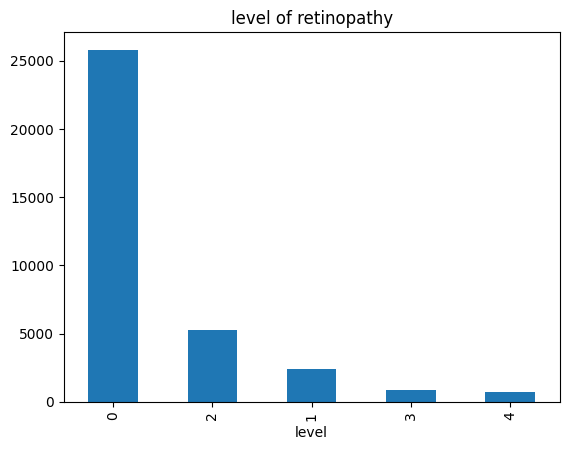

In [21]:
df_labels["level"].value_counts().plot(kind="bar")
plt.title("level of retinopathy")
plt.ylabel("")
plt.show()

0 → no DR
1 → mild
2 → moderate
3 → severe
4 → proliferative

I can see that the data is very imbalanced.

The data is very inbalanced. So the decision is to group 1, 2, 3, 4, together as 0: 'N0 DR',  1: 'Yes DR'.

Solution:
- Random under-sampling is useful but blunt.
- Using moderate under-sampling + augmentation + class_weight is the gold standard.

This ensures you don’t accidentally lose critical healthy examples.

In [22]:
print(df_labels.columns)

Index(['image', 'level'], dtype='object')


### Reviewing the **images**

In [23]:
# df_images = pd.read_csv(df_images)
# print(df_labels.head())

# Confirming folder variable
print("Images folder path:", df_images)
print("Example files inside:", os.listdir(df_images)[:5])

Images folder path: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7/resized_train_cropped/resized_train_cropped
Example files inside: ['33639_right.jpeg', '15655_left.jpeg', '12623_left.jpeg', '27550_right.jpeg', '7808_left.jpeg']


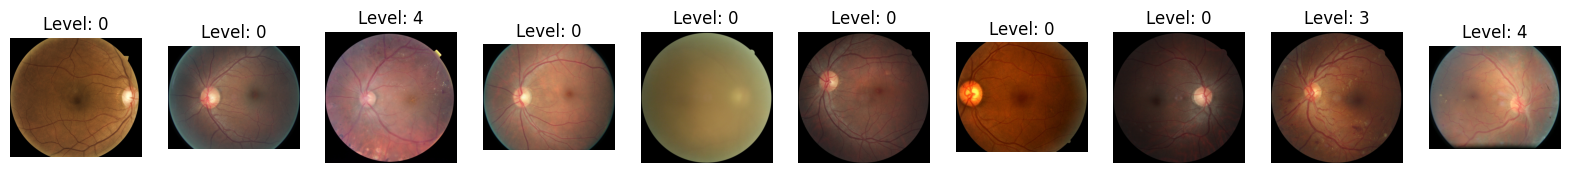

In [24]:
# picking random images
sample = df_labels.sample(10, random_state=42)

# plotting 10 random samples side by side for better overview
fig, axes = plt.subplots(1, 10, figsize=(20, 5))

for ax, (_, row) in zip(axes, sample.iterrows()):
    img_path = os.path.join(df_images, row['image'] + '.jpeg')
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Level: {row['level']}")
    ax.axis('off')
plt.show()

### Path Construction

In [25]:
# Adding image path to the label Dataframe, this is the full path
df_labels["path"] = df_labels["image"].apply(lambda x: os.path.join(df_images, x + ".jpeg"))

# I am only keeping the rows if they actually exist in the folder
df_labels = df_labels[df_labels['path'].apply(os.path.exists)].copy()

# Reviewing
print("Rows with valid filles:", len(df_labels))

Rows with valid filles: 35108


Now that we got 35108 back, we can see that we haven't lost any images or values.

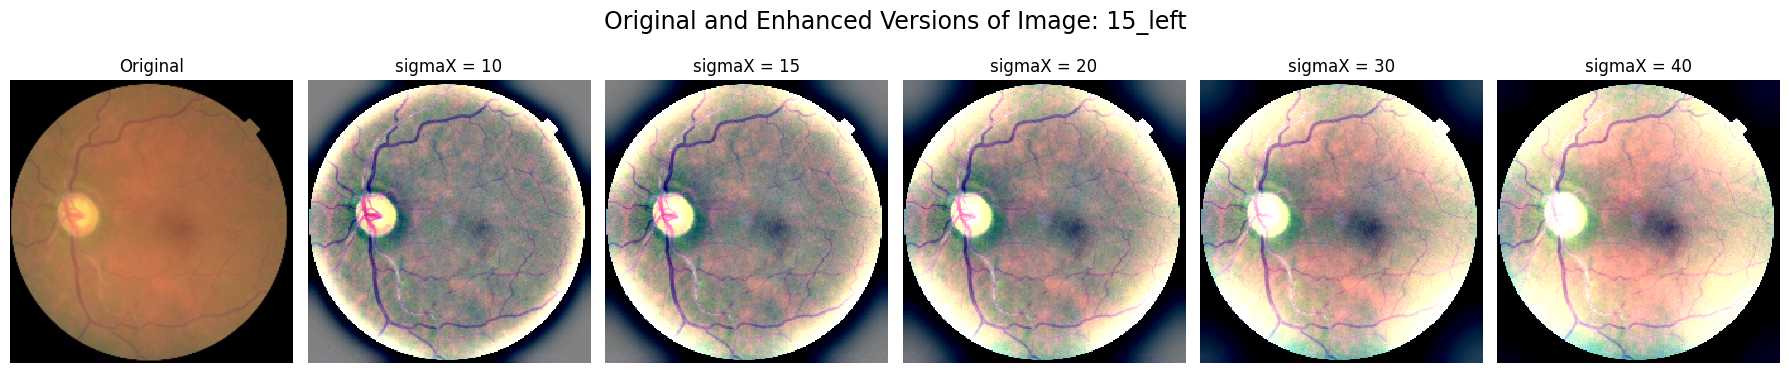

In [26]:
# Function to enhance the images
def enhance_retina_image(path, sigmaX=10):
    image = cv2.imread(path)
    if image is None:
        raise ValueError(f"Could not read the image from path: {path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)

    # Ensure valid float32 image in [0, 1]
    image = image.astype(np.float32) / 255.0

    return image

# Filtering positive cases (level > 0)
df_positive = df_labels[df_labels['level'] > 0].reset_index(drop=True)

# Example
img_id = df_positive['image'].iloc[0]
img_path = os.path.join(df_images, img_id + '.jpeg')

# Define sigmaX values to compare
sigma_values = [10, 15, 20, 30, 40]

# Plotting
plt.figure(figsize=(18, 4))

# Keeping the original image
original = cv2.imread(img_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
original = cv2.resize(original, (224,224))

plt.subplot(1, len(sigma_values) + 1, 1)
plt.imshow(original)
plt.axis('off')
plt.title("Original")

# Enhancing the images
for i, sigma in enumerate(sigma_values):
    # Applying the enhancement
    img = enhance_retina_image(img_path, sigmaX=sigma)
    plt.subplot(1, len(sigma_values) + 1, i + 2)
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')
    plt.title(f'sigmaX = {sigma}')

plt.suptitle(f'Original and Enhanced Versions of Image: {img_id}', fontsize=17)
plt.tight_layout()
plt.show()

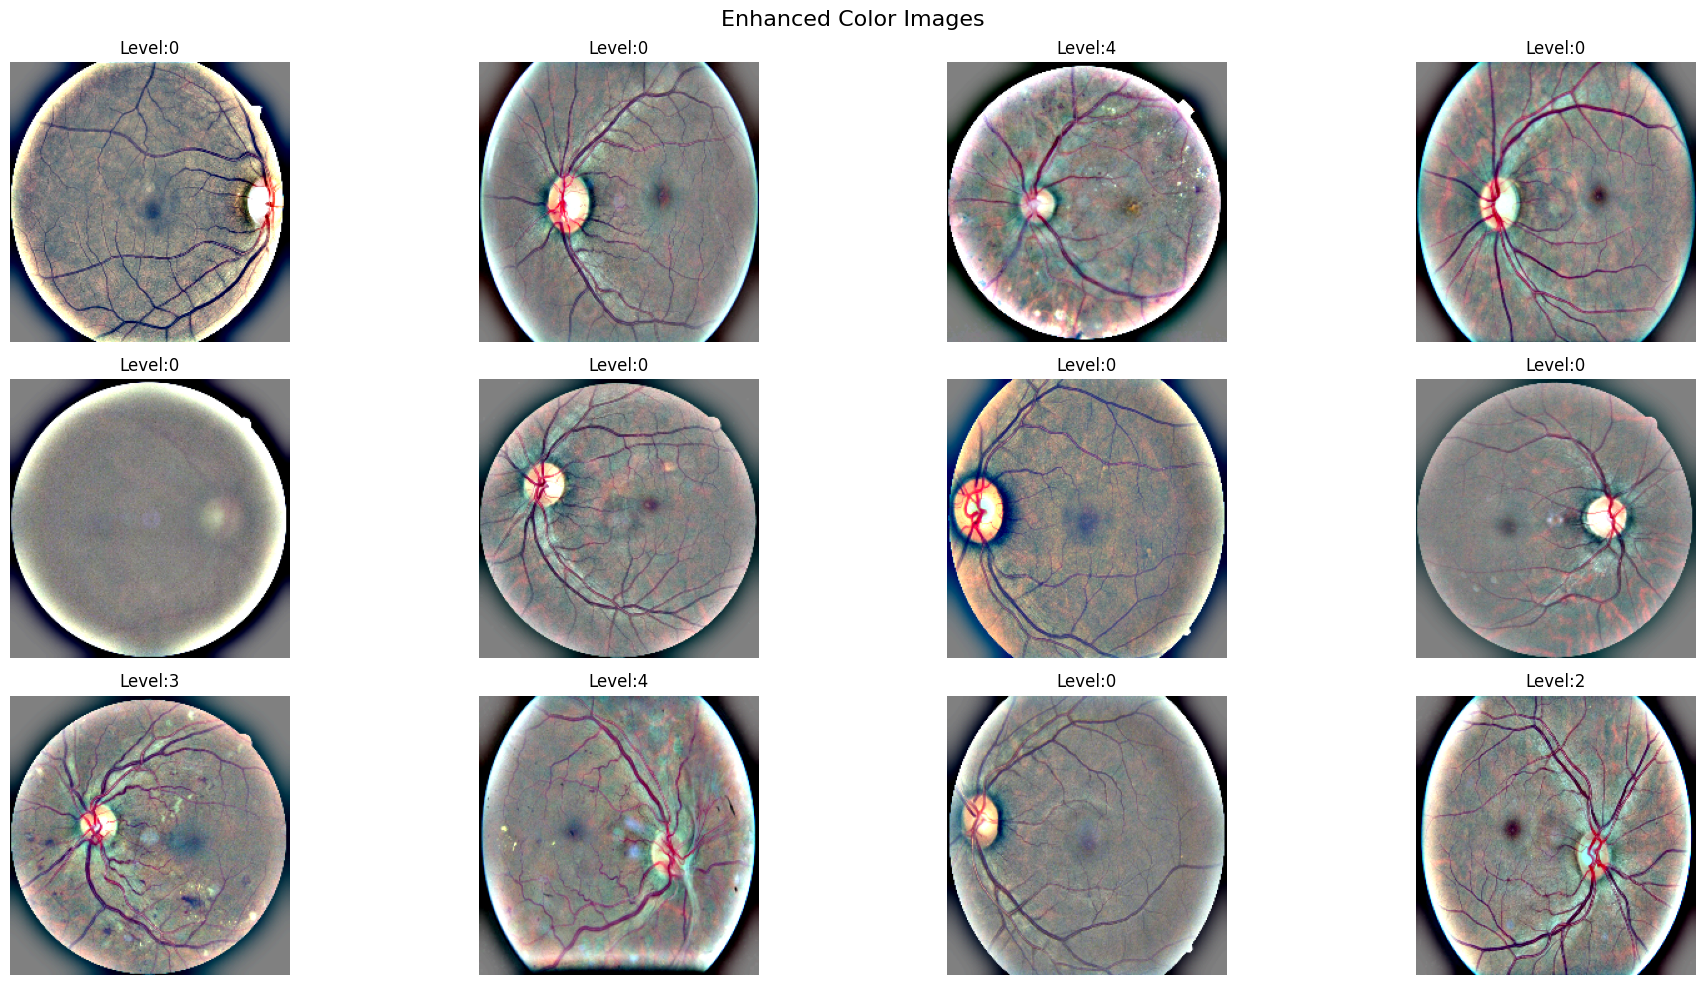

In [27]:
# Picking random samples of 12 images
sample_df = df_labels.sample(12, random_state=42)

# Plotting
plt.figure(figsize=(20, 10))

for i, row in enumerate(sample_df.itertuples()):
    try:
        image = enhance_retina_image(row.path, sigmaX=10)
        plt.subplot(3, 4, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Level:{row.level}")
    except:
        pass

plt.suptitle("Enhanced Color Images", fontsize=16)
plt.tight_layout()
plt.savefig("enhanced_images_grid.png", dpi=300)
plt.show()

In [31]:
# Outputfolder
output_dir = "processed_images"
os.makedirs(output_dir, exist_ok=True)


# Saving the enhanced images
for row in df_labels.itertuples():
  try:
    enhanced_img = enhance_retina_image(row.path, sigmaX=10)
    img_to_save = (enhanced_img *255).astype('uint8')
    save_path = os.path.join(output_dir, f"{row.image}.jpeg")
    plt.imsave(save_path, img_to_save)
  except Exception as e:
    print(f"Skipping {row.image}: {e}")

In [32]:
# Checking for some samples
print("Sample files in processed_images folder:")
print(os.listdir("processed_images")[:5])

Sample files in processed_images folder:
['33639_right.jpeg', '15655_left.jpeg', '12623_left.jpeg', '27550_right.jpeg', '7808_left.jpeg']


In [33]:
# Adding the processed image paths to the dataframe

# Pointing to the processed folder
processed_dir= "processed_images"

# Adding processed images
df_labels["processed_path"] = df_labels["image"].apply(
    lambda x: os.path.join(processed_dir, f"{x}.jpeg")
)

# Filtering again to keep only valid files
df_labels = df_labels[df_labels["processed_path"].apply(os.path.exists)].copy()
print("Processed images saved:", len(df_labels))

# Dropping the old path column if it exists
if "path" in df_labels.columns:
    df_labels.drop(columns=["path"], inplace=True)

# Renaming 'processed_path' to 'path' for compatibility with downstream code
df_labels.rename(columns={"processed_path": "path"}, inplace=True)

# Final check-up
print("Total processed images retained:", len(df_labels))
df_labels.head()

Processed images saved: 35108
Total processed images retained: 35108


,image,level,path
0,10_left,0,processed_images/10_left.jpeg
1,10_right,0,processed_images/10_right.jpeg
2,13_left,0,processed_images/13_left.jpeg
3,13_right,0,processed_images/13_right.jpeg
4,15_left,1,processed_images/15_left.jpeg


In [34]:
print(df_labels.head())

      image  level                            path
0   10_left      0   processed_images/10_left.jpeg
1  10_right      0  processed_images/10_right.jpeg
2   13_left      0   processed_images/13_left.jpeg
3  13_right      0  processed_images/13_right.jpeg
4   15_left      1   processed_images/15_left.jpeg


## 7. Binary Classification

In [35]:
# Adding Binary column by grouping 1, 2, 3, 4 together as 1 = 'Has DR', 0 = 'No DR'. - Data is very unbalanced.
df_labels['binary_level'] = df_labels['level'].apply(lambda x: 0 if x ==0 else 1)
print(df_labels[['level', 'binary_level']].head())

   level  binary_level
0      0             0
1      0             0
2      0             0
3      0             0
4      1             1


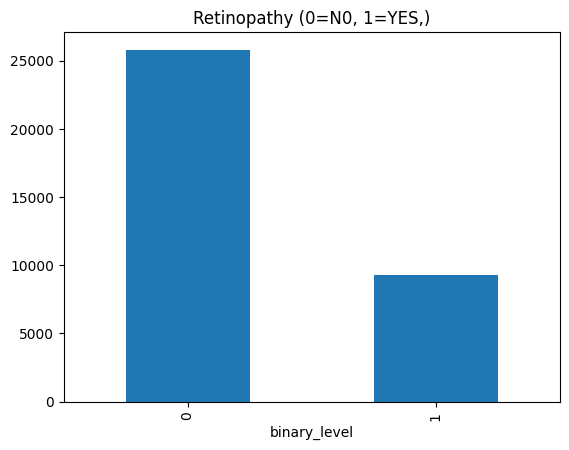

In [36]:
# Plotting to check
df_labels["binary_level"].value_counts().plot(kind="bar")
plt.title("Retinopathy (0=N0, 1=YES,)")
plt.ylabel("")
plt.show()

In [37]:
print(df_labels.head(10))
# print(df_labels.columns)

      image  level                            path  binary_level
0   10_left      0   processed_images/10_left.jpeg             0
1  10_right      0  processed_images/10_right.jpeg             0
2   13_left      0   processed_images/13_left.jpeg             0
3  13_right      0  processed_images/13_right.jpeg             0
4   15_left      1   processed_images/15_left.jpeg             1
5  15_right      2  processed_images/15_right.jpeg             1
6   16_left      4   processed_images/16_left.jpeg             1
7  16_right      4  processed_images/16_right.jpeg             1
8   17_left      0   processed_images/17_left.jpeg             0
9  17_right      1  processed_images/17_right.jpeg             1


## 8. Balance Dataset & Moderate Undersampling

### Moderate Undersampling
I am going to moderately undersample the data.

In [38]:
# Keep 2:1 (Moderate)
df_healthy = df_labels[df_labels['binary_level'] == 0]
df_dr = df_labels[df_labels['binary_level'] == 1]

desired_healthy = 2 * len(df_dr)
df_healthy_under = df_healthy.sample(desired_healthy, random_state=42)

balanced_labels = pd.concat([df_healthy_under, df_dr]).sample(frac=1, random_state=42).reset_index(drop=True)

balanced_labels['binary_level'].value_counts()

,count
binary_level,
0,18612
1,9306


I used moderate undersampling to keep the healthy class at twice the size of the DR-positive class, preserving useful healthy variation while reducing imbalance.

In [39]:
# Reviewing Tensorflow version
print(tf.__version__)

2.18.0


## 9. Class Weights

In [40]:
# Calculating the class_weight

classes = np.unique(balanced_labels['binary_level'])
weights = compute_class_weight(
    class_weight = 'balanced',
    classes = classes,
    y=balanced_labels['binary_level']
)
class_weight = dict(zip(classes, weights))
print(class_weight)

{np.int64(0): np.float64(0.75), np.int64(1): np.float64(1.5)}


np.int64(0): np.float64(0.75) --> healthy, gets weight 0.75
np.int64(1): np.float64(1.5) --> gets weight 1.5

- So if the model classifies a DR image --> the loss is multipliied by 1.5, which makes it more costly.
- If it misclassifies a healthy image --> loss is multiplied by 0.75, which is less costly.
In termsL It tells the model to pay extra attention to correctly detecting the DR.

For further developing during the training, pass:
- class_weight = {0: 0.75, 1: 1.5}


## 10. Train/Validation Split

In [41]:
# Splitting it into 80% training and 20% validation (stratify to keep label balance)
df_train, df_val = train_test_split(balanced_labels, test_size=0.2, stratify = balanced_labels['binary_level'], random_state=42)

# Checking train dataframe
print("Train:")
print(df_train['binary_level'].value_counts())

# Checking for valudation
print("\nValidation:")
print(df_val['binary_level'].value_counts())

Train:
binary_level
0    14889
1     7445
Name: count, dtype: int64

Validation:
binary_level
0    3723
1    1861
Name: count, dtype: int64


In [83]:
# Convert labels back to integer type for tf.data
df_train['binary_level'] = df_train['binary_level'].astype(int)
df_val['binary_level'] = df_val['binary_level'].astype(int)

## 11. ImageDataGenerators
Image generators for comparison and use.

#### Defining the generators

In [43]:
# Training with augementation

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    zoom_range = 0.2,
    brightness_range = [0.7, 1.3],
    horizontal_flip =True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [44]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = "",
    x_col ='path',
    y_col ='binary_level',
    target_size = (224, 224),
    batch_size = 32,
    class_mode ='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe = df_val,
    directory = None,
    x_col = 'path',
    y_col = 'binary_level',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary',
    shuffle = False
)

Found 22334 validated image filenames belonging to 2 classes.
Found 5584 validated image filenames belonging to 2 classes.


What I did so far:

1. Cleaned and prepared the dataset
- dropped extra columns
- verified I have 35108 valid image-label pairs
- created a binary label: 0 = No DR, 1 = Has DR

2. Used modeerate undersampling:
- reduced the healthy class to twice the size of DR (2:1)
- final count = healthy: 18.612,  DR: 9.306, Total: 27.918

3. Calculated class weights:
- {0: 0.75, 1: 1.5}
- Model willpenalises DR mistakes more than healthy mistakes.

4. Split into train/validation with stratify
- 80% train: Healthy: 14,889, DR: 7,445
- 20% validation: Healthy: 3,723, DR: 1,861

5. Converted labels to strings
- requrement by ImageDataGenerator

6. Defined Generators:
- train: uses augementations + rescaling
- validation: only rescaling
- Finding exat right number of images

Found 22334 validated image filenames belonging to 2 classes for Train.

Found 5584 validated image filenames belonging to 2 classes for validation.

This matches the split.
- 14,889 + 7,445 = 22,334 (train)
- 3,723 + 1,861 = 5,584 (validation)


Next step: Build and train the model
1. EfficientNetB0 block + compile + train (with class_weight)?
2. Also the custom CNN version side-by-side?
3. Or only EfficientNet for now, one clean block?

## 12. Tf.data Pipeline

In [45]:
# Turning the splits into tf.data.Dataset

# Parsing function
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [224, 224])
  image = image / 255.0
  return image, label

batch_size = 32

### Train dataset

In [84]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train['path'].values, df_train['binary_level'].values))
train_ds = train_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)

### Validation dataset

In [85]:
val_ds = tf.data.Dataset.from_tensor_slices((df_val['path'].values, df_val['binary_level'].values))
val_ds = val_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [48]:
# Inspecting 1 batch

for images, labels in train_ds.take(1):
  print(f"Images shape:", images.shape)
  print(f"Labels shape:", df_labels.shape)

Images shape: (32, 224, 224, 3)
Labels shape: (35108, 4)


### Computing class_weight

In [49]:
# Get unique classes
classes = np.unique(df_labels['binary_level'])
print("Classes:", classes)

# computing weights
weights = compute_class_weight(
    class_weight = 'balanced',
    classes = classes,
    y = df_train['binary_level'].astype(int) # Changing it back to int because for class weight you need to have it in int.
)

# Making dictionary for Keras
class_weight = dict(zip(classes, weights))
print("Classweights:", class_weight)

# safe casting to plain int and float types
class_weight = {int(k): float(v) for k, v, in class_weight.items()}

Classes: [0 1]
Classweights: {np.int64(0): np.float64(0.7500167909194707), np.int64(1): np.float64(1.4999328408327737)}


### Defining Focal Loss

In [63]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())  # avoid log(0)

        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        loss = -alpha_t * tf.pow(1 - p_t, gamma) * tf.math.log(p_t)

        return tf.reduce_mean(loss)
    return focal_loss

### Building & Compiling the model

In [66]:
# Loading the basemodel
base_model = EfficientNetB0(
    input_shape = (224, 224, 3),
    include_top = False,
    weights='imagenet'
)
base_model.trainable = False

# Building the full model
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x) # for Binary classification output

model = models.Model(inputs, outputs)

# Compiling the model in the optimizer and loss function
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss= binary_focal_loss(gamma=2.0, alpha=0.25), #loss='binary_crossentropy',
    metrics=['accuracy'] # e.g metrics['binary_accuracy']
)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Notes:
- Adam is an SGD (Stochastic Gradient Descent) algorithm that has an adaptive learning rate that makes it suitable for most problems without any parameter tuning (it is 'self tuning', in a sense). Adam is a great general-purpose optimizer.

- After I have defined the model, I added also a loss function, in this case 'binary_crossentropy', and Adam as optimizer.

- Gradient is a vector that tells us in what direction the weights need to go. And more precisely, it tells us how to change the weights to make the loss change fastest. The reason why we call it process gradient descent, because it uses gradient to descend the loss curve towards a minimum, Stochastics means 'determinede by chance', the training is stochastic because the batches are random samples from the dataset, thus why it's called SGD.

- Crosse-entropy function:
The problem with accuracy (and most other classification metircs) is that it can't bee used as a loss function. SGD needs a loss function that changes smoothly, but accuracy, being a ratio of counts, changes in "jumps". So, we have to choose a substitute to act as the loss function. So in this case it is the cross-entropy function.
- So for classification, what we want instead is a distance between probabilities, and this is what cross-entropy provides. Cross-entropy is a sort of measure for the distance from one probabillity distribution to another.
- Ideally we want the netework to predict the correct class with a probability 1.0. The furuther away the predicted probability is from 1.0, the greater the cross-entropy loss.

In [51]:
# Turning the splits into tf.data.Dataset and updating the parse_image

# Parsing function
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [224, 224])
  image = image / 255.0  # Rescale to [0, 1]

  # Apply data augmentation only during training
  if tf.keras.backend.learning_phase():
      image = tf.image.random_rotation(image, factor=0.15)  # Rotate by up to 30 degrees
      image = tf.image.random_zoom(image, zoom_factor=(0.2, 0.2)) # Zoom by up to 20%
      image = tf.image.random_brightness(image, max_delta=0.3) # Adjust brightness
      image = tf.image.random_flip_left_right(image) # Horizontal flip

  label = tf.cast(label, tf.float32)
  return image, label

batch_size = 32

Notes: Smaller batch sizes give noisier weight updates and loss curves. The reason is because each batch is a small sample of data abd smaller samples tend to give noicier estimates. So smaller batches can have an averaging effect though which can be beneficial.

Smaller learning rates makes the updates smaller and the training takes longer to converge. Large learning rates can speed up the training. Howeveer, when the leaerning rate is too large, the training can also completely fail.

In [81]:
# Recreating the dataset, but now as INT
train_ds = tf.data.Dataset.from_tensor_slices((
    df_train['path'].values,
    tf.cast(df_train['binary_level'].values, tf.int64) # Explicitly cast to int64
))

val_ds = tf.data.Dataset.from_tensor_slices((
    df_val['path'].values,
    tf.cast(df_val['binary_level'].values, tf.int64) # Explicitly cast to int64
))

train_ds = train_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

UnimplementedError: {{function_node __wrapped__Cast_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cast string to int64 is not supported [Op:Cast] name: 

In [72]:
# Unfreezing some layers of the base model
base_model.trainable = True

# Fine-tuning with many layers onwards
fine_tune_from = 100

# Freezing layers before the 'fine_tune_from' layer
for layer in base_model.layers[:fine_tune_from]:
    layer.trainable = False

# Recompiling the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), # Even lower learning rate for fine-tuning
    loss=binary_focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 3,841,629 (14.65 MB)

 Non-trainable params: 209,223 (817.28 KB)

### Training the model

In [86]:
# Adding the Callbacks
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience= 5,  # how many epochs to wait before stopping
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

# Training the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weight
)

Epoch 1/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6688 - loss: 0.0629

698/698 ━━━━━━━━━━━━━━━━━━━━ 68s 96ms/step - accuracy: 0.6688 - loss: 0.0629 - val_accuracy: 0.6665 - val_loss: 0.0658
Epoch 2/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6674 - loss: 0.0628

698/698 ━━━━━━━━━━━━━━━━━━━━ 79s 92ms/step - accuracy: 0.6674 - loss: 0.0628 - val_accuracy: 0.6667 - val_loss: 0.0636
Epoch 3/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 68s 96ms/step - accuracy: 0.6709 - loss: 0.0625 - val_accuracy: 0.6667 - val_loss: 0.0681
Epoch 4/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 85s 101ms/step - accuracy: 0.6708 - loss: 0.0623 - val_accuracy: 0.6667 - val_loss: 0.0662
Epoch 5/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6692 - loss: 0.0624

698/698 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.6692 - loss: 0.0624 - val_accuracy: 0.6669 - val_loss: 0.0634
Epoch 6/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 67s 96ms/step - accuracy: 0.6689 - loss: 0.0621 - val_accuracy: 0.6667 - val_loss: 0.0641
Epoch 7/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 64s 92ms/step - accuracy: 0.6690 - loss: 0.0621 - val_accuracy: 0.6665 - val_loss: 0.0658
Epoch 8/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 68s 97ms/step - accuracy: 0.6676 - loss: 0.0623 - val_accuracy: 0.6665 - val_loss: 0.0660
Epoch 9/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 82s 97ms/step - accuracy: 0.6683 - loss: 0.0619 - val_accuracy: 0.6667 - val_loss: 0.0635
Epoch 10/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 77s 90ms/step - accuracy: 0.6689 - loss: 0.0617 - val_accuracy: 0.6667 - val_loss: 0.0661


### Evaluate

When training the model, Keras provide updates on the loss as the model trains. So another way to view the loss is to simply plot it. The fit method keeps a record of the loss produced during training in a History object. So I'll convert the data to a Pandas dataframe, which makes the plotting easy.

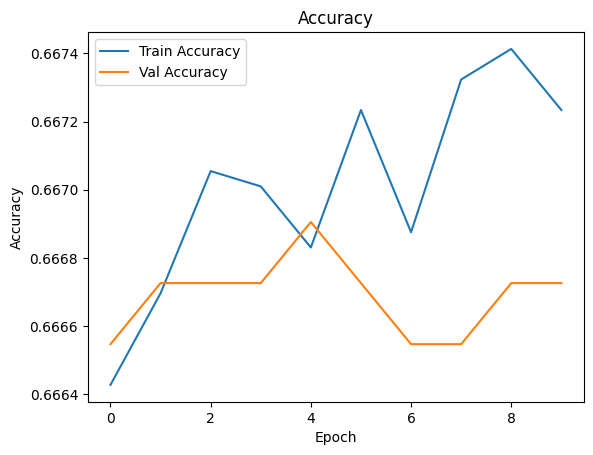

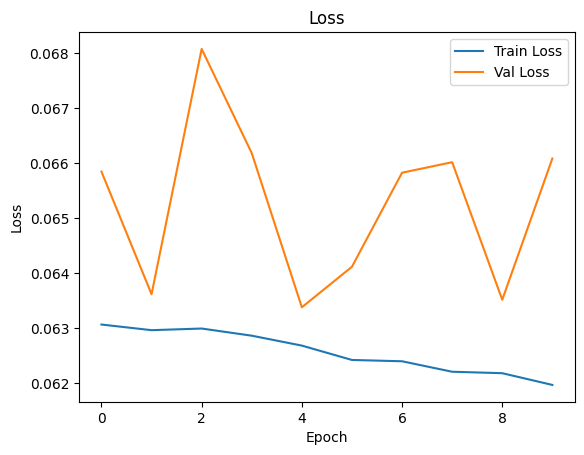

In [87]:
# Converting the training history to a dataframe

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [88]:
# Evaluating the Model

results = model.evaluate(val_ds)
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation Accuracy: {results[1]:.4f}")

175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6564 - loss: 0.0639
Validation Loss: 0.0634
Validation Accuracy: 0.6669


In [89]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get the true labels and predicted labels from the validation dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred_probs = model.predict(val_ds)
y_pred = (y_pred_probs > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step
Confusion Matrix:
[[3723    0]
 [1860    1]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80      3723
         1.0       1.00      0.00      0.00      1861

    accuracy                           0.67      5584
   macro avg       0.83      0.50      0.40      5584
weighted avg       0.78      0.67      0.53      5584



In [58]:
# # Making predictions on a few examples

# for images, labels in val_ds.take[1]:
#   preds = model.predict(images)
#   preds_binary = (preds >0.5).astype(int)
#   print("Predictions: ", preds_binary.flatteen())
#   print("True Labels: ", labels.numpy())

- At least 10 epochs
- confusion matrix


- deadline 2 weeks

### Reason for changing the learning rate

I reduced the learning rate of the Adam optimizer from its default to 0.0001 to help the model converge more effectively during training. The learning rate determines the size of the steps the optimizer takes when adjusting the model's weights to minimize the loss function.

A high learning rate can cause the optimizer to take steps that are too large, potentially overshooting the optimal weights or causing the training process to become unstable, especially when using a custom loss function like Focal Loss. By using a smaller learning rate, I am allowing the optimizer to take smaller, more precise steps towards the minimum of the loss function, which can lead to better performance and a more stable training process.

### My Next Steps

Now that I have a model with improved performance after implementing data augmentation and fine-tuning, here are the next steps I should consider:

**What I have improved and changed:**

*   **Handled Data Imbalance:** I used moderate undersampling and class weights to address the imbalance in the dataset.
*   **Enhanced Images:** I applied an image enhancement function to preprocess the images.
*   **Implemented Binary Classification:** I created a binary label (0 for No DR, 1 for Has DR).
*   **Used TensorFlow Data Pipeline:** I utilized `tf.data.Dataset` for efficient data loading and preprocessing.
*   **Applied Focal Loss:** I used a custom binary focal loss function to better handle the class imbalance during training.
*   **Reduced Learning Rate:** I lowered the learning rate of the Adam optimizer to help the model converge.
*   **Implemented Data Augmentation:** I added aggressive data augmentation to the training data pipeline.
*   **Fine-tuned Base Model:** I unfroze and fine-tuned some layers of the EfficientNetB0 base model.

**What I have done so far:**

*   Loaded and cleaned the dataset.
*   Performed exploratory data analysis.
*   Split the data into training and validation sets.
*   Built and compiled the EfficientNetB0 model.
*   Trained the model and evaluated its initial performance.
*   Troubleshooted data type issues in the data pipeline.
*   Re-trained the model after implementing data augmentation and fine-tuning.
*   Evaluated the improved model using the confusion matrix and classification report.

**Here are my next steps:**

1.  **Interpret the Classification Report in detail:** I need to carefully analyze the precision, recall, and F1-score for both the "No DR" (class 0) and "Has DR" (class 1) classes to understand the model's strengths and weaknesses for each.
2.  **Visualize the Training History:** I should plot the accuracy and loss curves from the training history again to visually assess the training progress and look for signs of overfitting or underfitting.
3.  **Experiment with different `fine_tune_from` values:** I can try unfreezing a different number of layers in the EfficientNetB0 base model during fine-tuning to see if it leads to further performance improvements.
4.  **Consider adjusting the classification threshold:** Instead of using a default threshold of 0.5 for binary classification, I can explore if a different threshold improves the balance between precision and recall for the "Has DR" class, depending on the importance of minimizing false positives versus false negatives for this medical task.
5.  **Potentially train for more epochs:** If the validation loss was still decreasing at the end of the last training run, I could try increasing the number of epochs or adjusting the Early Stopping patience to allow the model more time to converge.
6.  **Evaluate on a separate test set:** Ideally, I should evaluate the final model on a completely separate test dataset that was not used during training or validation to get an unbiased estimate of its real-world performance.